## Intro
This is my exploratory data analysis and model building for the Titanic dataset. The titanic dataset is one of the most widely known sample datasets where it can be used to predict who would survive using binary classification, and as also stated, this is my entry for the Kaggle competition. I will start by analyzing the data, then doing some data cleaning and model building to determine how accurate our model will be. We will start by loading our packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


Next, I will configure the plotting for my convenience. Tampering with the plotting features is really beneficial and it will make your visualizations beautiful. Using the rc() function from Matplotlib's Pyplot is more efficient, so there wouldn't be a need to repeatedly enter the same functions over and over.

In [2]:
#Configure plotting options
sns.set_style('darkgrid')
plt.rc('axes', labelsize=14, labelweight='bold', titlesize=16, titleweight='bold')
plt.rc('figure', figsize=(8,5))

Now that we have set up our packages and configurations, we can now load and analyze the data.

## Data Analysis

In [3]:
#Display float values in 4 decimal points
pd.set_option('display.float_format', lambda x: '%.4f' % x)

train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
df = pd.concat([train,test])
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0000,3,"Braund, Mr. Owen Harris",male,22.0000,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0000,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0000,1,0,PC 17599,71.2833,C85,C
2,3,1.0000,3,"Heikkinen, Miss. Laina",female,26.0000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0000,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0000,1,0,113803,53.1000,C123,S
4,5,0.0000,3,"Allen, Mr. William Henry",male,35.0000,0,0,373450,8.0500,NaN,S


In [4]:
print('Training dimensions:', train.shape)
print('Testing dimensions:', test.shape)
print('Full dimension:', df.shape)

Training dimensions: (891, 12)
Testing dimensions: (418, 11)
Full dimension: (1309, 12)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,1309.0000,655.0000,378.0201,1.0000,328.0000,655.0000,982.0000,1309.0000
Survived,891.0000,0.3838,0.4866,0.0000,0.0000,0.0000,1.0000,1.0000
Pclass,1309.0000,2.2949,0.8378,1.0000,2.0000,3.0000,3.0000,3.0000
Age,1046.0000,29.8811,14.4135,0.1700,21.0000,28.0000,39.0000,80.0000
SibSp,1309.0000,0.4989,1.0417,0.0000,0.0000,0.0000,1.0000,8.0000
Parch,1309.0000,0.3850,0.8656,0.0000,0.0000,0.0000,0.0000,9.0000
Fare,1308.0000,33.2955,51.7587,0.0000,7.8958,14.4542,31.2750,512.3292


I will create a function for displaying the column's categories to preserve code usage.

In [7]:
#Display categories of each feature
def displayUniqueFeatures(col):
    count = df[col].nunique()
    print('Unique features for %s: %d' % (col, count))
    if count < 50:
        print(df[col].unique())

for col in df.select_dtypes('object'):
    displayUniqueFeatures(col)

Unique features for Name: 1307
Unique features for Sex: 2
['male' 'female']
Unique features for Ticket: 929
Unique features for Cabin: 186
Unique features for Embarked: 3
['S' 'C' 'Q' nan]


In [8]:
#Drop unneeded columns
cat_cols = df.columns[df.dtypes == 'object']
cols_to_drop = [col for col in cat_cols if df[col].nunique() > 10]
cols_to_drop

train.drop(columns=['PassengerId'] + cols_to_drop, axis=1)
test.drop(columns=['PassengerId'] + cols_to_drop, axis=1)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5000,0,0,7.8292,Q
1,3,female,47.0000,1,0,7.0000,S
2,2,male,62.0000,0,0,9.6875,Q
3,3,male,27.0000,0,0,8.6625,S
4,3,female,22.0000,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S
414,1,female,39.0000,0,0,108.9000,C
415,3,male,38.5000,0,0,7.2500,S
416,3,male,NaN,0,0,8.0500,S


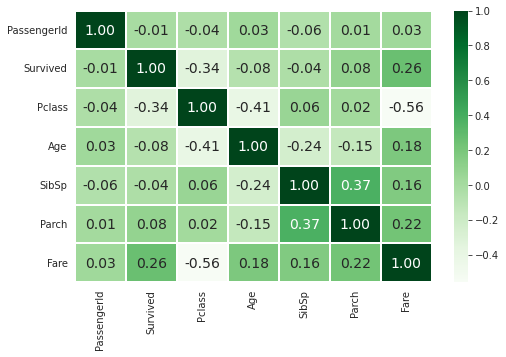

In [9]:
#Display correlation matrix
sns.heatmap(df.corr(), fmt='.2f', annot=True, cmap='Greens', linewidth=.1, annot_kws={'size': 14});

This dataset has no correlations, except for ticket class (Pclass) and fare, where more than 50% and less than -50% is considered a strong correlation.

### Visualizations

Again, I will use a function to plot pies for efficiency.

In [10]:
#It's easier to make a function displaying plots, so we don't have to enter the same parameters again
def make_pie(column):
    values = df[column].value_counts()
    plt.pie(values.values, labels=values.index, autopct='%1.1f%%', startangle=90, shadow=True)

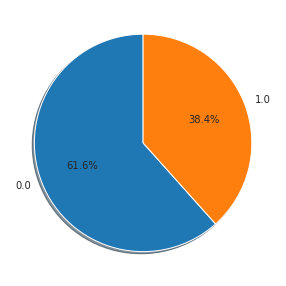

In [11]:
make_pie('Survived')

It turns out that most of the individuals in the Titanic did not survive the catastrophe.

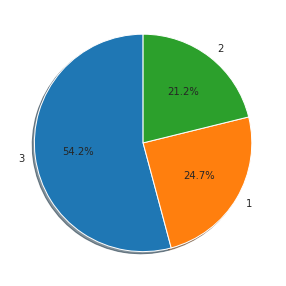

In [12]:
make_pie('Pclass')

3rd class appears to be the most frequent class. This could assume that the classes are price-based and/or have perks, meaning that this a lower-ranked class.

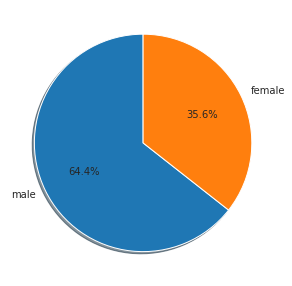

In [13]:
make_pie('Sex')

Most of the individuals are men.

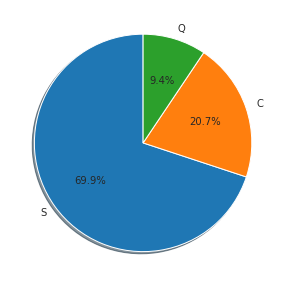

In [14]:
make_pie('Embarked')

The ship mostly consisted of Southamption individuals.

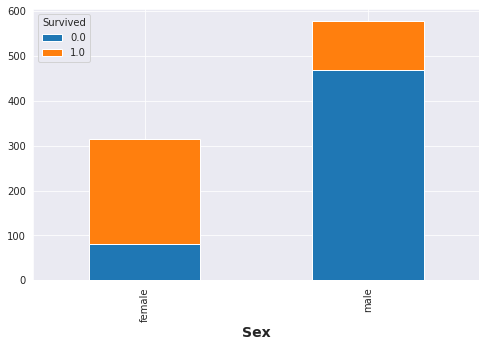

In [15]:
pd.crosstab(df.Sex,df.Survived).plot(kind='bar', stacked=True);

This plot says that it was mostly females that survived the incident. The length of the bars indicate the frequency of that category.

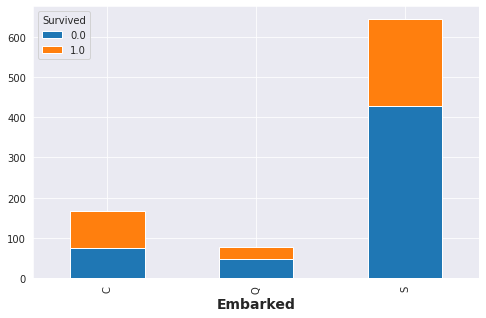

In [16]:
pd.crosstab(df.Embarked,df.Survived).plot(kind='bar', stacked=True);

Most of the casualties and survivals were from Southampton folks.

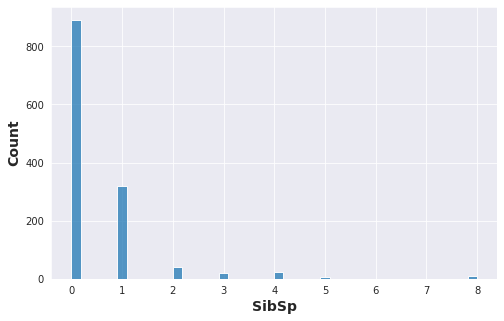

In [17]:
sns.histplot(df.SibSp);

Given the fact that this feature counts both siblings and spouses (according to the description of the data), it can be hard to tell if the individual was a sibling or somebody's spouse, especially with this histogram. So it is known that it's uncommon to have alot of siblings, and obviously, no person has more than one spouse, especially in 1912. So we could say that in the first two bars, most of the people in the Titanic were either single or didn't have any siblings. The second bar could indicate that those people were married and/or had a slight chance of having only one sibling. The other bars could indicate that a tiny portion of individuals had more than one sibling.

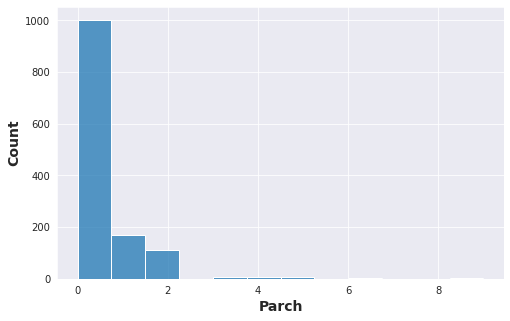

In [18]:
sns.histplot(df.Parch);

Just like this histogram, the Parch feature takes in the amount of both parents and/or children, which can be really confusing. This could be interpreted as individuals with children, since you can't have more than two parents. So it could be said that the tiny portion of people on the ship had more than two children, and the majority have no children.

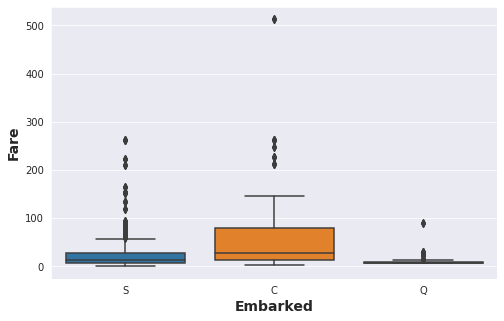

In [19]:
sns.boxplot(x='Embarked', y='Fare', data=df);

Cherbourg residents appeared to have paid the most expensive fares for the ship, while the other embarkments have paid the same amounts.

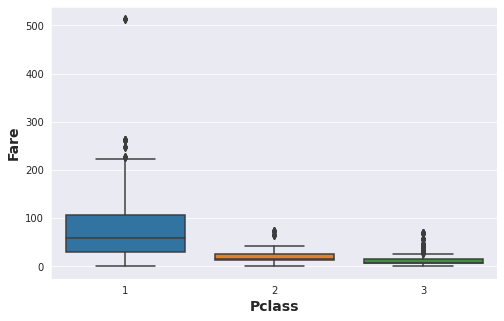

In [20]:
sns.boxplot(x='Pclass', y='Fare', data=df);

First class individuals paid the most out of everyone else, as suspected. The correlation table proves this fact.

### Data Cleaning

In [21]:
def get_null_info(df):
    null_sum = [df[col].isnull().sum() for col in df.columns]
    null_prob = [df[col].isnull().sum() / len(df) for col in df.columns]
    null_vals = pd.DataFrame({'amount': null_sum, 'probability': null_prob}, index=df.columns)
    return null_vals.sort_values('amount', ascending=False)

get_null_info(train)

,amount,probability
Cabin,687,0.7710
Age,177,0.1987
Embarked,2,0.0022
PassengerId,0,0.0000
Survived,0,0.0000
Pclass,0,0.0000
Name,0,0.0000
Sex,0,0.0000
SibSp,0,0.0000
Parch,0,0.0000


In [22]:
get_null_info(test)

,amount,probability
Cabin,327,0.7823
Age,86,0.2057
Fare,1,0.0024
PassengerId,0,0.0000
Pclass,0,0.0000
Name,0,0.0000
Sex,0,0.0000
SibSp,0,0.0000
Parch,0,0.0000
Ticket,0,0.0000


The Titanic data has missing values, more specifically the Cabin of each individual, which heavily lacks non-null values. The "Survived" column is nonexistent in the testing data. The Age and Embarked columns also have missing values in both datasets. We can fill the Cabin and Embarked entries with "Unknown", fill the missing fare value with the mean, and fill the missing ages with the median, because it makes no sense for ages to have an average, which doesn't represent a whole number.

*NOTE: The column transformer can also be used, but I have discovered that it gave my model a lower accuracy score.*

In [23]:
#Fill in missing values
train.Cabin.fillna('Unknown', inplace=True)
test.Cabin.fillna('Unknown', inplace=True)
train.Age.fillna(df.Age.median(), inplace=True)
test.Age.fillna(df.Age.median(), inplace=True)
train.Embarked.fillna('Unknown', inplace=True)
test.Embarked.fillna('Unknown', inplace=True)
test.Fare.fillna(df.Fare.mean(), inplace=True)

## Building the Model

Now that we have imputed the missing values, we can now build our model and get an accuracy score. I will use the Pipeline to encode the categorical data and then use the Random Forest Classifier, along with some hyperparameters to get the highest score.

In [24]:
#Using sklearn's Pipeline to build the model
pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)), 
                 ('rf', RandomForestClassifier(random_state=0))])

#Hyperparameters for our model
param_grid = {'rf__n_estimators': [10,20,30,50,100,500,1000], 
              'rf__criterion': ['gini','entropy'], 
              'rf__bootstrap': [True,False]}

#Data splitting
X_train = train.drop('Survived', axis=1)
y_train = train.Survived

#Model building
model = GridSearchCV(pipe, param_grid, scoring='accuracy')
model.fit(X_train,y_train)
print('Highest score possible: {:.4f}'.format(model.best_score_))

Highest score possible: 0.8283


We got an accuracy score of almost 83%, which is above the average (77%) of the scores in this competition. The hyperparameters definiely helped. The code below displays the parameters used to obtain the score:

In [25]:
print('Best parameters:')
for k, v in model.best_params_.items():
    print('%s: %s' % (k, v))

Best parameters:
rf__bootstrap: False
rf__criterion: gini
rf__n_estimators: 20


And here are all of the possible scores:

In [26]:
#This will create a table of scores with each hyperparameter combination
params = pd.DataFrame(model.cv_results_['params'])
params['score'] = model.cv_results_['mean_test_score']
params.sort_values('score', ascending=False)

,rf__bootstrap,rf__criterion,rf__n_estimators,score
15,False,gini,20,0.8283
24,False,entropy,50,0.8260
27,False,entropy,1000,0.8249
20,False,gini,1000,0.8238
26,False,entropy,500,0.8238
18,False,gini,100,0.8238
17,False,gini,50,0.8226
11,True,entropy,100,0.8215
19,False,gini,500,0.8204
14,False,gini,10,0.8204


Now that we are done, we can create our submission:

In [27]:
#Create CVS file for submission
output = pd.DataFrame({'PassengerId': test.index + 892, 'Survived': model.predict(test)})
output.to_csv('gender_submission.csv', index=False)
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


So it turns out that using Random Forest Classifier, along with some hyperparameters, slightly boosted the score which makes our model a little bit better. Comment for any feedback.